# Hvilke frekvenser bidrar pianoet med i refrenget til "Tropeau Bleu" av Cortex, og hvilke noter og akkorder tilsvarer dette?

## Introduksjon
Tropeau Bleu er en sang langet av cortex, sluppet i 1975, innenfor jazzsjangeren. Albumet av samme tittel som sangen er en klassiker i dag, og samples fra albumet finnes den dag i dag i instrumentalet til jazzete hiphop. Så vidt jeg vet er ikke sangen transponert, det er min oppfatning at dette er typisk for jazz. Likevel ønsker jeg å få til å spille sangen på piano selv, derfor skal jeg i dette essayet bruker Fourier- og Morlet transformasjoner for å se hvilke frekvenser er til stede i refrenget av sangen, samt rekkefølgen og samtidigheten av frekvensene. Deretter vil frekvensene spilles av i det som da blir en python-syntheziser, for å gjennskape refrenget.

## Initiell fouriertransformasjon av selv-generert note
Tropeau Bleu er en sang av mange lyder, og dermed mange frekvenser. En direkte fourier-transformasjon, selv med et sluttresultat sier i seg selv lite om Fast-fourier-transformsasjonen faktisk funket. en A-note genereres med python-synthesizeren, da denne har en lett-leselig frekvens på 400Hz. Først må vi velge ut hva slags moduler skal brukes. **Numpy** er en gjenganger og trenger null introduksjon. **scipy.io.wavfile** skal benyttes til både lesing, og generering av .wav filer, (Wave Audio File Format). **IPython.Display.Audio** brukes til å spille av .wav-filene.

In [12]:
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio

Vår oppfatning av lyd kommer fra trykkforskjeller i luften, i form av trykkbølger forskjellige bølgelengder på trykkbølgene som gir opphav til diverse frekvenser. Disse frekvensene lager resonans i basilarmembranen vår, som resulterer i signaler sendt til hjernen vår, og resulterer i vår oppfatning av forskjellige lyder. En A-note har en frekvens på 440Hz, altså 400 bølgetopper per sekund. ved bruk av .wav så kan datamaskinene lage disse lydene, hvis vi konstruerer den tilsvarende tidsavhengige svingningen $x = a\cos(\omega t), $ der $\omega=2\pi \cdot\textrm{frekvens}$

In [13]:
"""sine generating function"""
def generateCosine(length, frequency, SampleRate, amplitude):  # generates a sine, duh
    t = np.linspace(0, length, SampleRate * length)
    y = amplitude*np.cos(2*np.pi*frequency * t)
    return y
"""defining samplerate and generating sine function."""
# needs to be defined in a variable to function properly
Samplerate = 44000
x = generateCosine(1, 440, Samplerate, 0.5)
wavfile.write('440Hz.wav', Samplerate, x.astype(np.float32))
Audio('440Hz.wav')

Nå har vi en lydfil bestående av lyd med kun én frekvens. På dataen fra denne skal vi utføre en Fourier-transformasjon, med hensikt om å finne inneholdt frekvens(er) på svingningen(e).
Dette gjør vi ved å anvende "Fast Fourier Transform" algoritmen, en DFT (diskrete Fourier Transform) som er definert slik:
$$
X_k = \sum_{n=0}^{N-1}x_n e^{-2\pi k n / N}
$$
der $x_n$ er dataen som transformeres.  For lett anvendelse definerer jeg ikke denne algoritmen selv, men bruker scipy sin algoritme **scipy.fft.fft**, samt **matplotlib** for å vise frem transformasjonen, og **scipy.io.wavfile** for å lese dataen i wavfilen lagret tidligere. Vi forventer åpenbart å se $f=\pm 440$Hz.

(-1000.0, 1000.0)

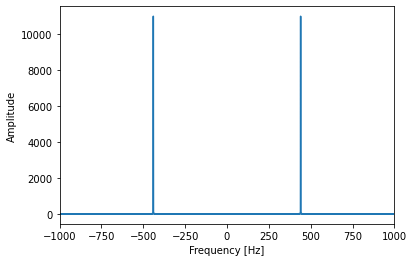

In [37]:
import matplotlib.pyplot as plt #brukes 
import scipy.fft as fft #behøves for Fast Fourier transform
from scipy.io import wavfile #wavfile.read() lives here


samplerate, data = wavfile.read('440Hz.wav')
x_n  = data # time series, N samples
N = data.shape[0] # number of samples
f_s = samplerate
dt = 1/f_s
T = N / f_s
x_fourier = fft.fft(x_n)
f_array = fft.fftfreq(N,dt)

plt.plot(f_array,np.abs(x_fourier))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.xlim(-1000,1000)

Nå har vi et "proof of concept" på at frekvenser faktisk *kan* hentes ut av .wav filer med FFT, og nå skal det undersøkes om algoritmen tåler en lengre fil og mer støy. Til dette har jeg valgt "Lisa gikk til skolen" spilt på kjøkkenutstyr, kildevideo her: https://www.youtube.com/watch?v=MU-SgbJ0bCk. Denne videoen ble lastet ned som .wav fil.

Text(0, 0.5, 'Amplitude')

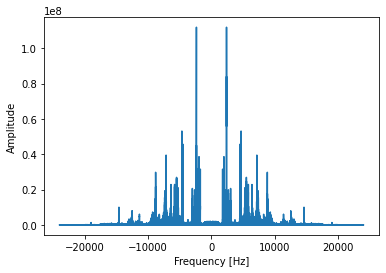

In [48]:
samplerate, data = wavfile.read('Lisa_gikk_til_skolen.wav')
x_n  = data[:,0] # time series, N samples
N = data.shape[0] # number of samples
f_s = samplerate
dt = 1/f_s
T = N / f_s
x_fourier = fft.fft(x_n)
f_array = fft.fftfreq(N,dt)
plt.plot(f_array,np.abs(x_fourier))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')


Det er vanskelig å bedømme fra plottet om FFT'en nødvendigvis gir mening. Det vi vet fra før er at frekvensene skal være godt innenfor det "hørebare" spektret av frekvenser, det vil si godt under 9kHz. 

(0.0, 8000.0)

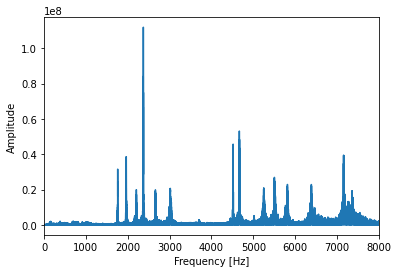

In [43]:
plt.plot(f_array,np.abs(x_fourier))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.xlim(0,8000)

In [63]:
from playsound import playsound
a = np.where(np.abs(x_fourier) >1e8)
print(a)
print(np.shape(a))
for i in a[0]:
    x = generateCosine(1,f_array[i],Samplerate,0.1)
    wavfile.write('Lisa_recreate.wav', Samplerate, x.astype(np.float32))
    playsound('Lisa_recreate.wav')

(array([ 39904,  39906, 767592, 767594]),)
(1, 4)


In [29]:
# implementer morlet wavelet i tidsdomenetet
def wavelet_td(omegaa, K, tk, tn):
    psi = C*( np.exp(-1j*omegaa*(tn-tk)) - np.exp(-K**2))*np.exp(-omegaa**2*(tn-tk)**2/(2*K)**2)
    return psi # returner wavelet ̈en, for gitte parametre

# wavelet transformen (i tidsdomenet)
def wavelet_transform_td(t, tk, xn, omegaa, K, N):
    A =  wavelet_td(omegaa,K,tk,t)
    gamma = np.zeros(N, dtype=np.complex )
    gamma = np.sum(np.conjugate(A)*xn)
    return gamma # returnerer gamma, for en gitt omegaa
# diagramfunksjon (felles for tids- og Fourierdomenet)

def wavelet_diagram(t, xn, omega_range, K, N):
    M = len(omega_range)
    diagram = np.zeros((M,N),dtype=np.complex)
    tk = t.copy()
    for i in range(N):
        for j in range(M):
            diagram[j,i] = wavelet_transform_td(t,tk[i], xn,omega_range[j],K,N)
    return diagram # returnerer et 2D diagram for en gitt K
# generere og plotte wavelets
K_vals = [6, 60]
tk = 0
C = 1
for K in K_vals:
    omegas = np.logspace(np.log10(80), np.log10(200), N) * 2 * np.pi # definere hvike analysefrekvenser du vil bruke her
    waveletDiagram6 = wavelet_diagram(t, x, omegas, K, N) # dette kallet gir ut en 2D diagram, og en gitt tidserie, valgt K-verdi og set av ønskete omegas
    plt.pcolormesh(t, omegas / 2.0 / np.pi, np.absolute(waveletDiagram6), shading='auto')
    plt.text(0.6,100,f'K={K}')
    plt.xlabel('time [s]')
    plt.ylabel('frequency [Hz]')
    plt.show()

MemoryError: Unable to allocate 9.49 TiB for an array with shape (807498, 807498) and data type complex128